<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/Explore_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install george

In [2]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import george
from george import kernels
import pandas as pd
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
data = pd.read_excel('/content/drive/My Drive/Hailisu.xlsx')

for col in data.columns:
  newcol = col.split("(")[0]
  data.rename(columns={col:newcol}, inplace=True)

data.set_index("TIMESTAMP", inplace=True)

data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

myData = data[["ET0", "VPD", "Rn", "T"]].ffill()
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(myData)
pca_data = PCA().fit_transform(z_data);
pca_trafo = PCA().fit(z_data);
data["P1"] = pca_data[:,0]
data["P2"] = pca_data[:,1]


# data["dET0"] = data["ET0"]-np.median(data["ET0"])

# data["ET1"] = data["ET0"] - data["ET0"].rolling('7d').apply(lambda x: x[:len(x)-1].mean())
data["ET1"] = data["ET0"].shift(1, freq='D')
data["ET2"] = data["ET0"] / data["ET1"]
data["ET2"] = data["ET2"].fillna(1)
# data["MA"] = data["ET0"].rolling('7d').apply(lambda x: x[:len(x)-1].mean())
# data["ET3"] = data["ET2"] - data["ET2"].shift(1, freq='D')

# data["ET3"].plot()

data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,ET1,ET2
TIMESTAMP,,,,,,,,,,,,,,,,
1990-01-01,1,4.5,-15.9,1.4,74.0,-20.3,-10.8,2.194157,0.049189,0.014773,0.067364,0.353247,-2.604686,0.219401,NaN,1.000000
1990-01-02,2,6.3,-14.7,1.2,55.0,-21.6,-7.2,2.455747,0.098182,0.016148,0.067364,0.708336,-2.433856,0.237608,0.353247,2.005214
1990-01-03,3,6.5,-10.5,1.8,63.0,-15.0,-5.6,2.851274,0.105714,0.021875,0.067364,0.773378,-2.218240,0.177261,0.708336,1.091823
1990-01-04,4,6.8,-14.6,1.4,71.0,-18.5,-8.6,2.698292,0.057183,0.016267,0.067364,0.455943,-2.477608,0.140149,0.773378,0.589548
1990-01-05,5,5.8,-15.2,1.1,55.0,-22.2,-5.9,2.000768,0.090000,0.015562,0.067364,0.627822,-2.522159,0.310003,0.455943,1.376974


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


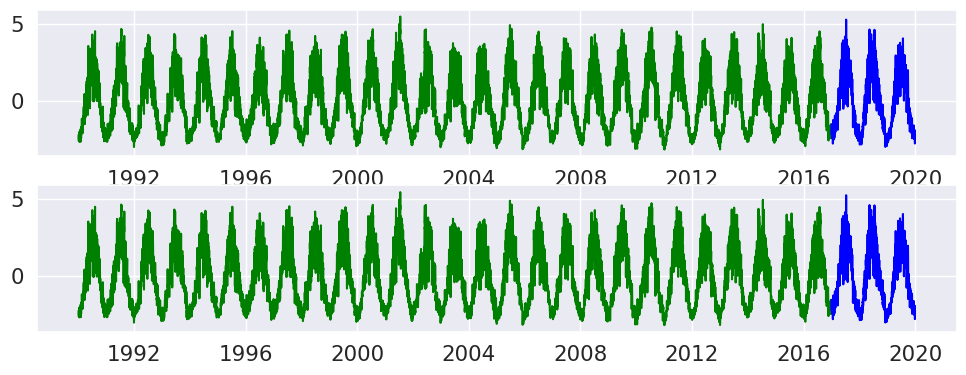

In [212]:
fig = py.figure(figsize=(10,15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(7,1) ; p=0

subData = data.loc[:"2016-12-31"]
N = len(subData)
x = subData.index
y = subData["P1"].ffill()
z = subData["P1"].ffill()
plt.subplot(gs[0]).plot(x, y, color='green')

subData_cross = data.loc["2017":]
N_cross = len(subData_cross)
x_cross = subData_cross.index
y_cross = subData_cross["P1"].ffill()
z_cross = subData_cross["P1"].ffill()
plt.subplot(gs[0]).plot(x_cross, y_cross, color='blue')

plt.subplot(gs[1]).plot(x, z, color='green')
plt.subplot(gs[1]).plot(x_cross, z_cross, color='blue')


In [244]:
def metrics(y1, y2):
  y1 = y1.reshape(-1)
  y2 = y2.reshape(-1)
  RMSE = np.sqrt(np.mean((y1-y2)**2))
  MAE = np.mean(np.abs(y1-y2))
  R2 = r2_score(y1, y2)
  print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
########################################
def Mlinear(theta, X):
    n = X.shape[1]
    M = theta[: n]
    B = theta[n] 
    y = X.dot(M) + B
    return y
########################################

def LNR(X, y):
    n = X.shape[1]
    def step(theta):
        yp_linear = Mlinear(theta, X)
        # return np.sum((y-yp_linear)**2)
        return np.mean(np.abs(y-yp_linear))

    return step
########################################

def funcMAX(func, X, y, addParam = 0, maxiter=500, method='L-BFGS-B', verbose=False):
  t1 =  datetime.now()
  ###########################################
  n = X.shape[1]
  # Maximum Likelihood
  Param_init = np.random.rand(n+addParam)
  result = minimize(func(X, y), Param_init, 
                method=method, options={"maxiter":maxiter})
  print("--------------------")
  if verbose:
    print(result)
  ###########################################
  if not verbose: 
    print("Fit Success: ", result.success)
  t2 =  datetime.now()
  print("Execution time: ", t2-t1)
  print("--------------------")
  return result

In [245]:
def linearML(y, y_cross, nDelay = 3, z=None, z_cross=None):

  XS, ys = dataPrepare(y, nDelay, z=z)
  XS_cross, ys_cross = dataPrepare(y_cross, nDelay, z=z_cross)
  
  print("Training data X-shape: ", XS.shape)
  print("Training data y-shape: ", ys.shape)
  print("Test data X-shape: ", XS_cross.shape)
  print("Test data y-shape: ", ys_cross.shape)

  # training the linear model
  theta = funcMAX(LNR, XS, ys, addParam = 1).x

  yp_cross = Mlinear(theta, XS_cross)
  yp = Mlinear(theta, XS)

  metrics(ys, yp)
  metrics(ys_cross, yp_cross)

  plt.plot(np.abs(theta), 'ro')

  return ys, yp, ys_cross, yp_cross

In [246]:


def dataPrepare(y, n = 3, z=None):
  N = len(y)
  
  if z is not None:
    XS = np.zeros((N-n, 2*n))
  else:
    XS = np.zeros((N-n, n))
  ys = np.zeros(N-n)
  for i in range(0, N-n-10):
    XS[i,:n] = y[i:i+n]
    if z is not None:
      XS[i,n:2*n] = z[i:i+n]
    ys[i] = y[i+n]
  
  return XS, ys


Training data X-shape:  (9852, 10)
Training data y-shape:  (9852,)
Test data X-shape:  (1085, 10)
Test data y-shape:  (1085,)
--------------------
Fit Success:  True
Execution time:  0:00:00.111389
--------------------
MAE: 0.41  RMSE: 0.61  R^2: 0.89
MAE: 0.42  RMSE: 0.63  R^2: 0.89
Training data X-shape:  (9852, 10)
Training data y-shape:  (9852,)
Test data X-shape:  (1085, 10)
Test data y-shape:  (1085,)
--------------------
Fit Success:  True
Execution time:  0:00:00.157761
--------------------
MAE: 0.41  RMSE: 0.61  R^2: 0.89
MAE: 0.42  RMSE: 0.63  R^2: 0.89


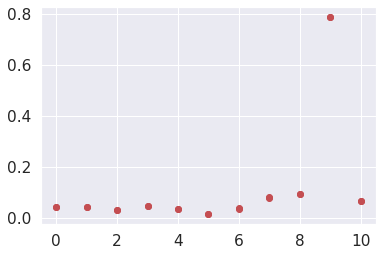

In [247]:
nDelay = 10
ys, yp, ys_cross, yp_cross = linearML(y, y_cross, nDelay = nDelay)
zs, zp, zs_cross, zp_cross = linearML(z, z_cross, nDelay = nDelay)


In [248]:
def dataPrepare2(y, z, n = 3,):

  N = len(y)
  XS = np.zeros((N-n, n))
  ys = np.zeros(N-n)

  for i in range(0, N-n):
    XS[i,:n] = z[i:i+n]   # all past residulas
    
    ys[i] = y[i+n]
  # 
  return XS, ys

--------------------
Fit Success:  True
Execution time:  0:00:00.028381
--------------------
MAE: 0.42  RMSE: 0.62  R^2: 0.89
MAE: 0.44  RMSE: 0.65  R^2: 0.89


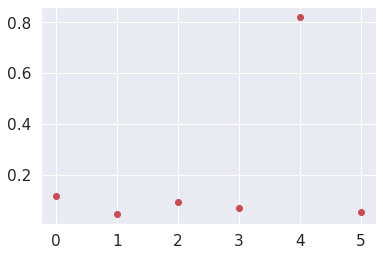

In [249]:
mDelay = 5

XS2, ys2 = dataPrepare2(ys, zs, n=mDelay)
XS_cross2, ys_cross2 = dataPrepare2(ys_cross, zs_cross, n=mDelay)

theta2 = funcMAX(LNR, XS2, ys2, addParam=1).x
yp_cross2 = Mlinear(theta2, XS_cross2)
yp2 = Mlinear(theta2, XS2)
metrics(ys2, yp2)
metrics(ys_cross2, yp_cross2)
plt.plot(np.abs(theta2), 'ro')

In [250]:
from scipy.stats import spearmanr

yr = ys-yp
zr = zs-zp
corr, _ = spearmanr(yr[1:], zp[:-1])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.016


(0.0, 200.0)

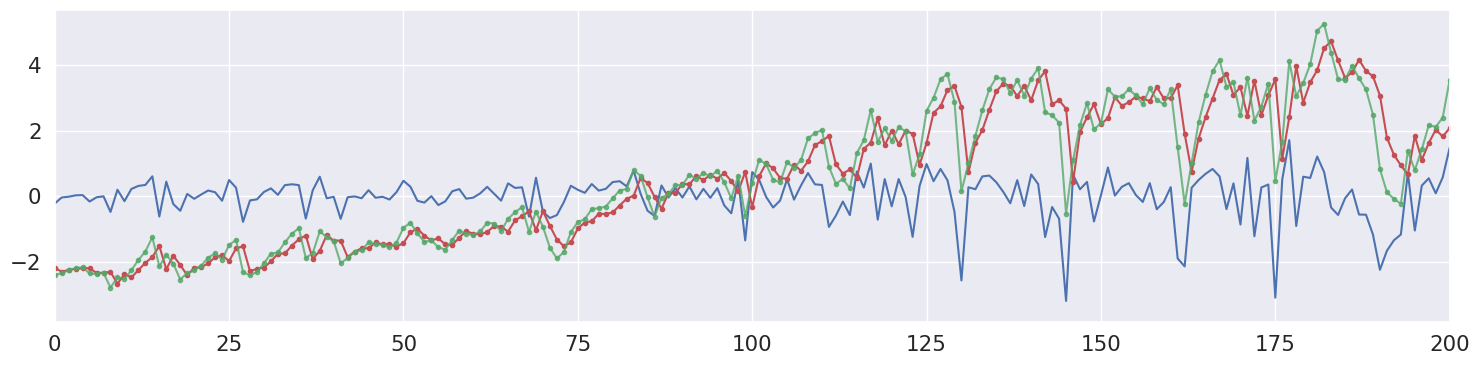

In [251]:
fig = py.figure(figsize=(15, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.plot(ys_cross-yp_cross)
ax.plot(yp_cross, 'r.-',  alpha=1)
ax.plot(ys_cross, 'g.-', alpha=0.8)

ax.set_xlim(0,200)

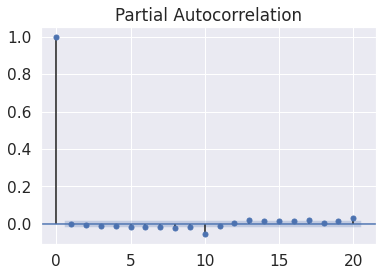

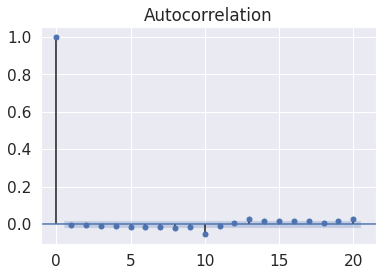

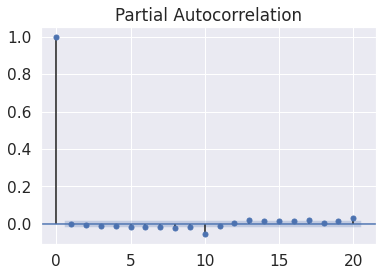

In [241]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ys-yp, lags=20)
plot_pacf(ys-yp, lags=20)

Spearmans correlation: -0.058


-1.1100189874361535e-06

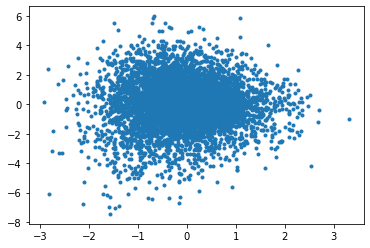

In [14]:
yr = ys-yp

plt.plot(yp[1:] - ys[:-1], yr[1:], '.')

corr, _ = spearmanr(yr[1:], yp[1:] - ys[:-1])
print('Spearmans correlation: %.3f' % corr)

np.mean(yr)

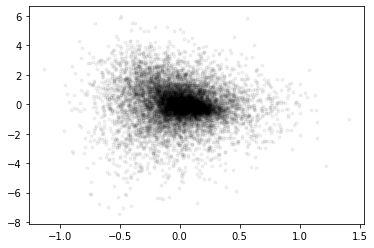

In [15]:
# plt.plot(ys[1:] - ys[:-1], yr[1:], 'b.', alpha=0.01)

plt.plot(zp[1:] - zs[:-1], yr[1:], 'k.', alpha=0.05)

In [16]:
data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,ET1,ET2
TIMESTAMP,,,,,,,,,,,,,,,,
1990-01-01,1,4.5,-15.9,1.4,74.0,-20.3,-10.8,2.194157,0.049189,0.014773,0.067364,0.353247,-2.604686,0.219401,NaN,1.000000
1990-01-02,2,6.3,-14.7,1.2,55.0,-21.6,-7.2,2.455747,0.098182,0.016148,0.067364,0.708336,-2.433856,0.237608,0.353247,2.005214
1990-01-03,3,6.5,-10.5,1.8,63.0,-15.0,-5.6,2.851274,0.105714,0.021875,0.067364,0.773378,-2.218240,0.177261,0.708336,1.091823
1990-01-04,4,6.8,-14.6,1.4,71.0,-18.5,-8.6,2.698292,0.057183,0.016267,0.067364,0.455943,-2.477608,0.140149,0.773378,0.589548
1990-01-05,5,5.8,-15.2,1.1,55.0,-22.2,-5.9,2.000768,0.090000,0.015562,0.067364,0.627822,-2.522159,0.310003,0.455943,1.376974


In [17]:
myData = data[["ET0", "VPD", "Rn", "T"]].dropna()

print(len(myData))
myData.head()

10957


,ET0,VPD,Rn,T
TIMESTAMP,,,,
1990-01-01,0.353247,0.049189,2.194157,-15.9
1990-01-02,0.708336,0.098182,2.455747,-14.7
1990-01-03,0.773378,0.105714,2.851274,-10.5
1990-01-04,0.455943,0.057183,2.698292,-14.6
1990-01-05,0.627822,0.090000,2.000768,-15.2


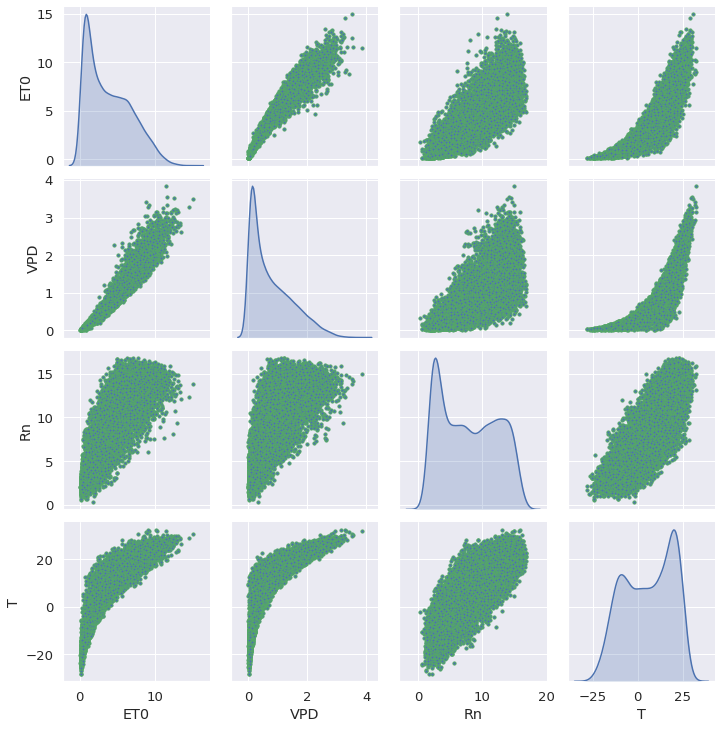

In [18]:
import seaborn as sns
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.2)
pp = sns.pairplot(myData, diag_kind="kde", markers=".", plot_kws=dict(s=40, edgecolor="g", linewidth=1),diag_kws=dict(shade=True))


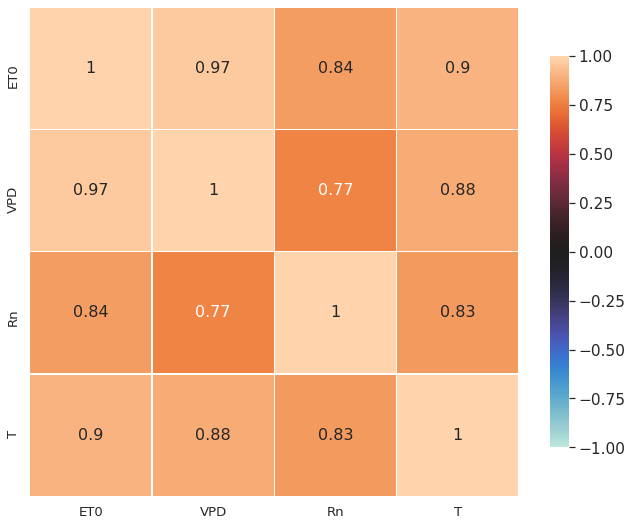

In [19]:


corr = myData.corr()

### Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

### Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

### Generate a custom diverging colormap
#cmap = sns.diverging_palette(110, 20, as_cmap=False)

sns.set(font_scale=1.4)

### Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmin=-1,vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 16}, annot=True) # , mask=mask)


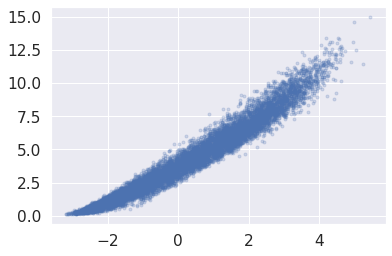

In [20]:
plt.plot(data['P1'], data["ET0"], '.', alpha=0.2)

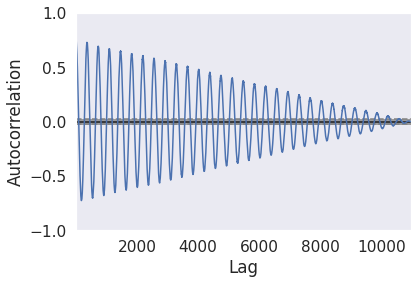

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data["ET0"])


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.ET0   No. Observations:                10956
Model:                ARIMA(10, 1, 0)   Log Likelihood              -18495.240
Method:                       css-mle   S.D. of innovations              1.309
Date:                Tue, 25 Aug 2020   AIC                          37014.479
Time:                        20:38:28   BIC                          37102.099
Sample:                    01-02-1990   HQIC                         37044.004
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.656e-05      0.004      0.005      0.996      -0.007       0.007
ar.L1.D.ET0     -0.3585      0.010    -37.597      0.000      -0.377      -0.340
ar.L2.D.ET0     -0.4205      0.010    -41.69

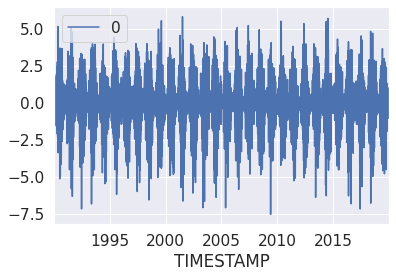

In [22]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(data["ET0"], order=(10,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [23]:
!pip install pyramid-arima


In [196]:
from pyramid.arima import auto_arima


stepwise_model = auto_arima(data.loc["1990"]["ET0"], start_p=10, start_q=5,
                           max_p=15, max_q=15, d=1, max_order=30,
                           seasonal=False, stationary=False, trace=True, information_criterion='hqic',
                           suppress_warnings=False, error_action='ignore')
print(stepwise_model.aic())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(10, 1, 5); AIC=1279.348, BIC=1345.599, Fit time=11.868 seconds
Fit ARIMA: order=(0, 1, 0); AIC=1376.755, BIC=1384.549, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1364.767, BIC=1376.458, Fit time=0.023 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1342.706, BIC=1354.398, Fit time=0.036 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(9, 1, 5); AIC=1267.469, BIC=1329.824, Fit time=8.581 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(9, 1, 4); AIC=1276.371, BIC=1334.829, Fit time=7.392 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(9, 1, 6); AIC=1279.658, BIC=1345.909, Fit time=11.505 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(8, 1, 4); AIC=1271.958, BIC=1326.518, Fit time=5.300 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


Fit ARIMA: order=(10, 1, 6); AIC=nan, BIC=nan, Fit time=nan seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(8, 1, 5); AIC=1258.178, BIC=1316.635, Fit time=5.483 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(8, 1, 6); AIC=1277.553, BIC=1339.907, Fit time=6.225 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(7, 1, 4); AIC=1277.255, BIC=1327.918, Fit time=3.607 seconds
Fit ARIMA: order=(7, 1, 5); AIC=1276.859, BIC=1331.419, Fit time=4.104 seconds
Total fit time: 67.817 seconds
1258.1775078650908


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [209]:
train = data.loc['2016-11-01':'2017-01-01']["ET0"]
test = data.loc['2017-01-02':'2017-01-10']["ET0"]

stepwise_model.fit(train)
future_forecast = stepwise_model.predict(len(test))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: Converge

In [210]:
train.shape

(62,)

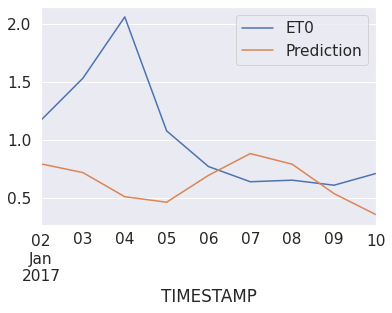

In [211]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
pd.concat([test,future_forecast],axis=1).plot()
